<span style="font-size:36px"><b>Model Inference</b></span>

Copyright &copy; 2020 Gunawan Lumban Gaol

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language overning permissions and limitations under the License.

# Import Packages

In [1]:
import os
import sys
import glob
import warnings

import yaml
import numpy as np
import IPython.display as ipd
import librosa.display as ld
import matplotlib.pyplot as plt
from pydub.utils import mediainfo
from tqdm.auto import tqdm

from gurih.data.splitter import Splitter
from gurih.data.normalizer import AudioNormalizer
from gurih.features.extractor import MFCCFeatureExtractor
from gurih.models.model import BaselineASRModel
from gurih.models.decoder import CTCDecoder
from gurih.models.utils import CharMap

%load_ext autoreload
%autoreload 2

In [2]:
def init(Pipeline, model_idx=None):
    """
    Initialize model in Pipeline.
    
    Parameters
    ----------
    Pipeline : Pipeline
        correcty configured pipeline
    model_idx : int
        number indicating model step in pipeline
    
    Returns
    -------
    Pipeline : Pipeline
        initialized pipeline
    """
    if model_idx is None:
        raise ValueError('Please provide model_idx param indicating model steps in pipeline.')
    
    model = Pipeline[model_idx]
    model.compile()
    model.load(model.dir_path)
    
    return Pipeline

In [3]:
def clean_mfcc(x_freq):
    """
    For visualization, remove frequency array with zero values
    on 2nd to last dimension of mfcc because earlier zero pad
    
    Parameters
    ----------
    x_freq : numpy.ndarray[shape=(frames, n_mfcc)]
        mfcc sequence
        
    Returns
    -------
    x_freq : list [shape=(:idx_remove, n_mfcc)]
        clean mfcc sequence
    """
    check = np.abs(np.round(x_freq))
    idx_remove = None
    for i in range(check.shape[0], -1, -1):
        stop = check[i:, 1:].any()
        if stop:
            idx_remove = i+1
            return x_freq[:idx_remove]

In [4]:
def infer(X, Pipeline, sep='\n', debug=False, plot=False, progressbar=True):
    """
    Create audio transcript for given audio filename.
    
    Parameters
    ----------
    X : numpy.ndarray[shape=(m, )]
        numpy array of audio filenames
    Pipeline : Pipeline
        initialized pipeline
    sep : str
        separator string for prediction output chunk
    debug : bool, [default=False]
        if True, print output shape of each pipeline process
    plot : bool, [default=False]
        if True, will plot normalized audio waveform and frequency
        domain features spectrum. Note that by enabling this, the
        pipeline will require more memory to store variables for
        plotting.
    progressbar : bool, [default=False]
        if True, will draw progress bar on inference process

    Returns
    -------
    y_preds : numpy.ndarray[shape=(m, c)]
        audio transcript of given file input, with chunks denoted
        by sep parameters
    """
    # Preprocessing Stage
    X = Pipeline[0].fit_transform(X)
    
    y_preds = []
    if progressbar is True: X = tqdm(X)
    for x in X:
        if x.shape[0] != 1 and Pipeline[0].mono is False:
            warnings.warn("Performing channel split and transcripting"
                          " for each channel. You can force mono"
                          " process by passsing mono=True on the"
                          " first pipeline step.")
        y_pred_c = []
        for x_c in x:
            x_c = np.expand_dims(x_c, axis=0)
            if plot is True: x_c_cache = x_c.copy()  # store normalized waveform
            if debug is True: print(x_c.shape)
            
            # Preprocessing
            for pipe in Pipeline[1:3]:
                x_c = pipe.fit_transform(x_c)
                if debug is True: print(x_c.shape)
            if plot is True: x_freq_cache = x_c.copy()  # store frequency features

            # Processing (Model)
            x_c = Pipeline[3].predict(x_c)
            if debug is True: print(x_c.shape)
                
            # Post-processing
            y_pred = Pipeline[4].fit_predict(x_c)
            y_pred_str = sep.join([y for y in y_pred])
            
            if plot is True:
                # Create figure for visualization
                plt.figure(figsize=(15, 6))
                plt.subplot(2, 1, 1)
                _ = ld.waveplot(np.asfortranarray(x_c_cache)[0], sr=sr)
                plt.title("Normalized Audio")
                plt.subplot(2, 1, 2)
                _ = ld.specshow(clean_mfcc(x_freq_cache.reshape(-1, x_freq_cache.shape[-1])).T, sr=sr, y_axis='log')
                plt.title("MFCC Features Audio")
                plt.tight_layout()
                plt.show()
            if debug is True: print(y_pred_str+'\n')
            
            y_pred_c.append(y_pred_str)
            
        y_preds.append(y_pred_c)
        
    return y_preds

# Inference Pipeline

## Create with Public API

Create your own pipeline using available public API from `gurih` packages.

In [4]:
# Define base parameters for your pipeline.
sr = 16000
force_mono = False

Create the pipeline:
1. The minimum pipeline should be `AudioNormalizer`, `Splitter`, and `gurih.models.model` instance.
2. Depending on the model, you could add extra decoder part to get string output.
3. This minimum pipeline will just use the single features (amplitude) from signals as input of the model.

In [25]:
pipeline = [
    AudioNormalizer(sample_rate=sr,
                    mono=force_mono,
                    write_audio_output=False,  # don't output normalized audio
                    output_dir="",
                    encode=False),  # don't output .json
    Splitter(max_frame_length=16000*30+81,  # sample-rate * (sr_norm / sr_mfcc * stride_mfcc) + (sr_mfcc * stride_mfcc / 2 + 1)
             strides=16000*30+81,
             padding='same',
             low_memory=False),
    MFCCFeatureExtractor(sample_rate=sr,
                         frame_size=0.025,
                         frame_stride=0.01,
                         filter_num=26,
                         cep_num=13,
                         NFFT=512,
                         low_freq=0,
                         high_freq=None,
                         pre_emphasis_coeff=0.97,
                         cep_lifter=22,
                         dct_type=2,
                         dct_norm="ortho",
                         append_energy=True,
                         append_delta=True,
                         low_memory=False,
                         write_output=False,
                         output_dir="."),
    BaselineASRModel(input_shape=(3000, 39), 
                     vocab_len=29, 
                     training=False,  # pass false to not save model config
                     dir_path="../../models/Model010b/BaselineASR_f200_k11_s2_pvalid_nlstm200_ndense29.h5",
                     doc_path="../../docs/Model010b/"),
    CTCDecoder(CharMap.IDX_TO_CHAR_MAP)
]

Model directory is set to ../../models/Model010b/BaselineASR_f200_k11_s2_pvalid_nlstm200_ndense29.h5
Documentation directory is set to ../../docs/Model010b/



In [26]:
# Save created pipeline
config_filename = "../../docs/Model010b/config.yaml"
with open(config_filename, 'w') as f:
    f.writelines(yaml.dump(pipeline))

## Load Saved Pipeline

Optionally, you can also load your `.yaml` preconfigured pipeline file.

In [34]:
config_filename = "../../docs/Model010b/config.yaml"
with open(config_filename, 'r') as f:
    pipeline = yaml.full_load(f)

In [35]:
pipeline

 CTCDecoder(idx_to_char_map={0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e',
                             6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k',
                             12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p',
                             17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u',
                             22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z',
                             27: '.', 28: ',', 29: '%'})]

## Initialize Pipeline

First, prepare the model by compiling and loading trained model.

In [36]:
model_idx = 3
pipeline = init(pipeline, model_idx=model_idx)

Model: "BaselineASR_f200_k11_s2_pvalid_nlstm200_ndense29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, 3000, 39)]        0         
_________________________________________________________________
masking (Masking)            (None, 3000, 39)          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 1495, 200)         86000     
_________________________________________________________________
bidirectional (Bidirectional (None, 1495, 400)         641600    
_________________________________________________________________
the_output (TimeDistributed) (None, 1495, 30)          12030     
Total params: 739,630
Trainable params: 739,630
Non-trainable params: 0
_________________________________________________________________

Loaded model ../../models/Model010b/BaselineASR_f200_k11_s2_pvalid_nlstm200_n

## Create Audio Transcript

Use the pipeline to create audio transcript. You just simply use `infer` method which accepts a `Pipeline` object and a saved model path.

In [62]:
# Multiple files from a directory
input_dir = "../../dataset/sample/"
mp3_files = glob.glob(input_dir+"*.mp3")
X = mp3_files
print(f"Total audio files: {len(X)}")

Total audio files: 11


In [63]:
X

['../../dataset/sample\\2019-09-03_Annisa Rahmawaty_3903350662_INT.mp3',
 '../../dataset/sample\\20190807_3902961838_Putri Despita_PTS.mp3',
 '../../dataset/sample\\20190819_3903089815_Muhamad Iqbal_PTS.mp3',
 '../../dataset/sample\\20190904_3900300934_Denny Fauzi_ NI.mp3',
 '../../dataset/sample\\20190905_3903379373_Noni Simangunsong_INT.mp3',
 '../../dataset/sample\\20190905_3903384721_Eva Suryaningsih.mp3',
 '../../dataset/sample\\202102_1.mp3',
 '../../dataset/sample\\239382.mp3',
 '../../dataset/sample\\Agung Ibrahim_85363151864_3903181630_20190821_INT.mp3',
 '../../dataset/sample\\CRS_M4_RTP_11766328359.mp3',
 '../../dataset/sample\\CRS_PreDD_PTP_11750082079.mp3']

Create transcription from input audio by following steps:
1. If channels > 1, split audio files into each channel
2. For each channel, if audio `frames > max_seq_length` then the audio will be splitted before transcription

In [64]:
y_preds = infer(X, pipeline, sep='\n', progressbar=True)
y_preds.shape

D:\Anaconda2019\envs\gurih\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Performing channel split and transcripting for each channel. You can force mono process by passsing mono=True on the first pipeline step.


(11, 2)

# Inference Pipeline with Plot

Inference pipeline with plot, great for single file usage to inspect more details.

In [67]:
# Single file
mp3_file = "../../dataset/sample/202102_1.mp3"
x = np.array([mp3_file])

In [68]:
x

array(['../../dataset/sample/202102_1.mp3'], dtype='<U33')

Create transcription from input audio by following steps:
1. If channels > 1, split audio files into each channel
2. For each channel, if audio `frames > max_seq_length` then the audio will be splitted before transcription

D:\Anaconda2019\envs\gurih\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Performing channel split and transcripting for each channel. You can force mono process by passsing mono=True on the first pipeline step.


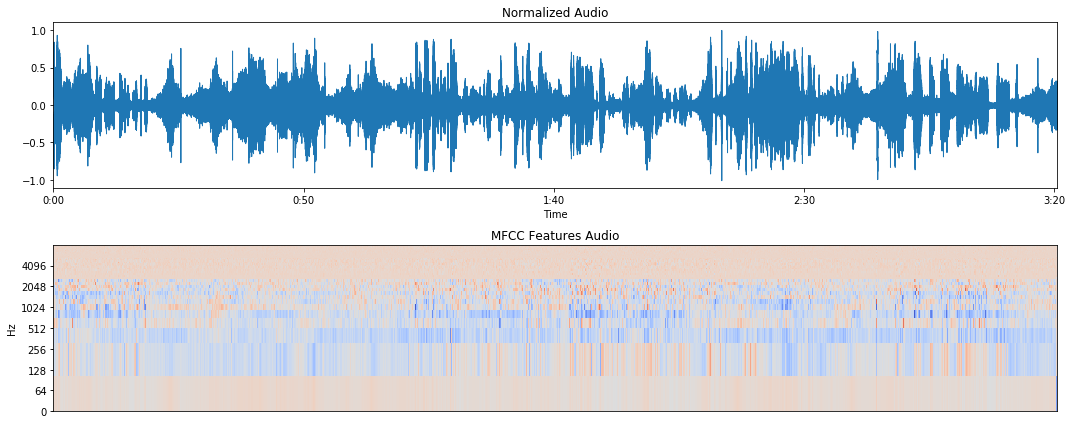

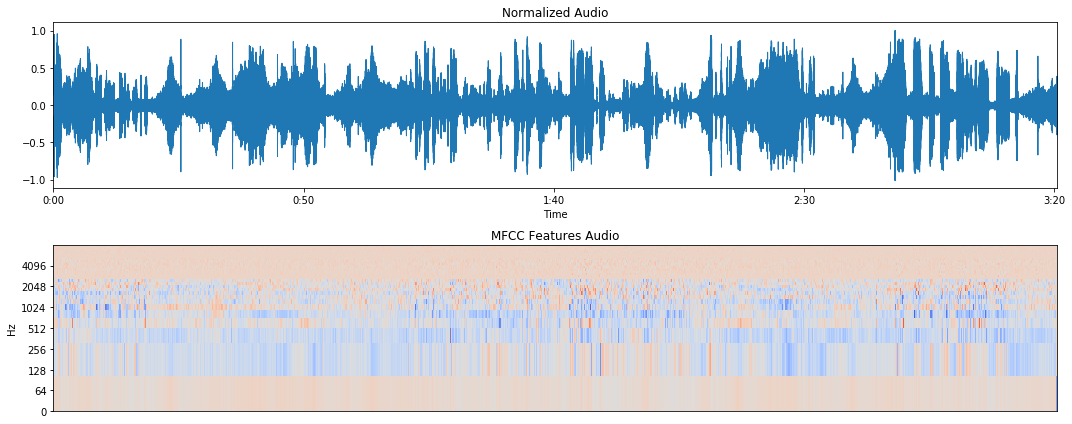

(1, 2)

In [71]:
y_pred = infer(x, pipeline, sep='\n', plot=True, progressbar=False)
y_pred.shape

Run below cell to hear what the audio is like.

In [72]:
ipd.Audio(x[0])

You can then inspect the output prediction from the pipeline.

In [74]:
y_pred

array([['iniadangkiunudionguaia tau kopa pangi lsa ia da be a tangba d beakurari uputneraf ratua pilania\n\nmeipakankiareatadakanu hawadamupu bara teuahanauan akagyasama paga atara eraga a ema ukalu oaiota mora r.\nadeka ea awa ala yani parte teya ia ati aralahada tama gaeh mea la eka peu esala ia kag wohabne opakelesukangu da meda bildatu akama sa baku orada yata bedaga atulangtu oran an ya a mau omarg ng\nratu ae mo geatau atla a oa mongia arata a a an nadaugtu kan uka a aia u ura.a pu a uangha ia i e e eu\niumimtaku peran peryatangari tetagaei ma eka taenan tempoahaiko ela t erek ba a\nteponya sda tutu da mendeadimari edari ari satuiruare ea a rasan ana kna fartan rangka terlpata rasi.',
        'iniadadankunun diongu lati oua tutoh ikopan poni lsa dia ma erana tangba he beakuari ukuntilegaf a pilenia\n\nme pankiara e bagagan hawadamugpa bar euahanuan akagya kama perga hakara ermaeada da uatamu pemau alu oai a mara y r.\nake ka eha korar ala ala yentiu olta dengadianra agi paralahar